<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px\" align="left">

## _*Hamiltonian and Gate Characterization*_ 

* **Last Updated:** March 8, 2019
* **Requires:** qiskit-terra 0.8, qiskit-ignis 0.1.1, qiskit-aer 0.2

This notebook gives examples to demonstrate how to user the ``characterization.hamiltonian`` and ``characterization.gates`` modules in ``qiskit-ignis``. For a theory background see the [Ignis Community Notebooks]( https://github.com/Qiskit/qiskit-tutorials/tree/master/community/ignis).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import qiskit
from qiskit.providers.aer.noise.errors.standard_errors import coherent_unitary_error
from qiskit.providers.aer.noise import NoiseModel

from qiskit.ignis.characterization.hamiltonian import ZZFitter, zz_circuits

from qiskit.ignis.characterization.gates import (AmpCalFitter, ampcal_1Q_circuits, 
                                                 AngleCalFitter, anglecal_1Q_circuits, 
                                                 AmpCalCXFitter, ampcal_cx_circuits, 
                                                 AngleCalCXFitter, anglecal_cx_circuits)

# Measuring ZZ

The ``characterization.hamiltonian.zz_circuits`` module builds the circuits to perform an experiment to measure ZZ between a pair of qubits.  ZZ here is defined as the energy shift on the $|11\rangle$ state,

$$H=\omega_0 (1-\sigma_{Z,0})/2 +\omega_1 (1-\sigma_{Z,1})/2 + \xi |11\rangle\langle 11|$$

The experiment to measure $\xi$ is to perform a Ramsey experiment on Q0 (H-t-H) and repeat the Ramsey with Q1 in the excited state. The difference in frequency between these experiments is the rate $\xi$

In [2]:
# ZZ rates are typically ~ 100kHz so we want Ramsey oscillations around 1MHz
# 12 numbers ranging from 10 to 1000, logarithmically spaced
# extra point at 1500
num_of_gates = np.arange(0,150,5)
gate_time = 0.1

# Select the qubits whose ZZ will be measured
qubits = [0]
spectators = [1]

# Generate experiments
circs, xdata, osc_freq = zz_circuits(num_of_gates, gate_time, qubits, spectators, nosc=2)

One of the features of the fitters are that we can split the circuits into multiple jobs and then give the results to the fitter as a list. Demonstrated below.

In [3]:
# Set the simulator with ZZ
zz_unitary = np.eye(4,dtype=complex)
zz_unitary[3,3] = np.exp(1j*2*np.pi*0.02*gate_time)
error = coherent_unitary_error(zz_unitary)
noise_model = NoiseModel()
noise_model.add_nonlocal_quantum_error(error, 'id', [0], [0,1])

# Run the simulator
backend = qiskit.Aer.get_backend('qasm_simulator')
shots = 500
# For demonstration purposes split the execution into two jobs
print("Running the first 20 circuits")
backend_result1 = qiskit.execute(circs[0:20], backend,
                                shots=shots, noise_model=noise_model).result()
print("Running the rest of the circuits")
backend_result2 = qiskit.execute(circs[20:], backend,
                                shots=shots, noise_model=noise_model).result()

Running the first 20 circuits
Running the rest of the circuits


ZZ Rate: 19.773830 kHz


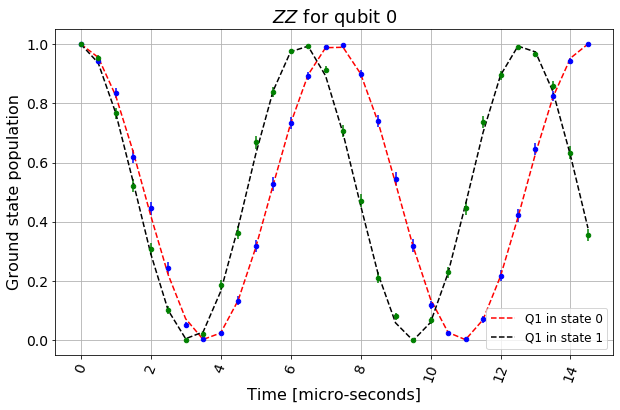

In [4]:
%matplotlib inline
# Fit the data to an oscillation

plt.figure(figsize=(10, 6))
initial_a = 1
initial_c = 0
initial_f = osc_freq 
initial_phi = -np.pi/20

# Instantiate the fitter
# pass the 2 results in as a list of results
fit = ZZFitter([backend_result1, backend_result2], xdata, qubits, spectators,
                   fit_p0=[initial_a, initial_f, initial_phi, initial_c],
                   fit_bounds=([-0.5, 0, -np.pi, -0.5],
                               [1.5, 2*osc_freq, np.pi, 1.5]))

fit.plot_ZZ(0, ax=plt.gca())
    
print("ZZ Rate: %f kHz"%(fit.ZZ_rate()[0]*1e3))
plt.show()

## Amplitude Error Characterization for Single Qubit Gates

Measure the amplitude error in the single qubit gates. Here this measures the error in the $\pi/2$ pulse. Note that we can run multiple amplitude calibrations in parallel. Here we measure on qubits 2 and 4. 

In [5]:
qubits = [4,2]
circs, xdata = ampcal_1Q_circuits(10, qubits)

This shows the sequence of the calibration, which is repeated application of Y90 (U2[0,0]). Note that the measurements are mapped to a minimal number of classical registers in order of the qubit list.

In [6]:
print(circs[2])

                                                                      
q1_0: |0>─────────────────────────────────────────────────────────────
                                                                      
q1_1: |0>─────────────────────────────────────────────────────────────
         ┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐   ┌─┐
q1_2: |0>┤ U2(0,0) ├┤ U2(0,0) ├┤ U2(0,0) ├┤ U2(0,0) ├┤ U2(0,0) ├───┤M├
         └─────────┘└─────────┘└─────────┘└─────────┘└─────────┘   └╥┘
q1_3: |0>───────────────────────────────────────────────────────────╫─
         ┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─┐ ║ 
q1_4: |0>┤ U2(0,0) ├┤ U2(0,0) ├┤ U2(0,0) ├┤ U2(0,0) ├┤ U2(0,0) ├┤M├─╫─
         └─────────┘└─────────┘└─────────┘└─────────┘└─────────┘└╥┘ ║ 
 c1_0: 0 ════════════════════════════════════════════════════════╩══╬═
                                                                    ║ 
 c1_1: 0 ═══════════════════════════════════════════════════════════╩═
      

In [7]:
# Set the simulator 
# Add a rotation error
err_unitary = np.zeros([2,2],dtype=complex)
angle_err = 0.1
for i in range(2):
    err_unitary[i,i] = np.cos(angle_err)
    err_unitary[i,(i+1) % 2] = np.sin(angle_err)
err_unitary[0,1] *= -1.0

error = coherent_unitary_error(err_unitary)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error, 'u2')

# Run the simulator
backend = qiskit.Aer.get_backend('qasm_simulator')
shots = 500
backend_result1 = qiskit.execute(circs, backend,
                                 shots=shots, noise_model=noise_model).result()

Rotation Error on U2: 0.008128 rads


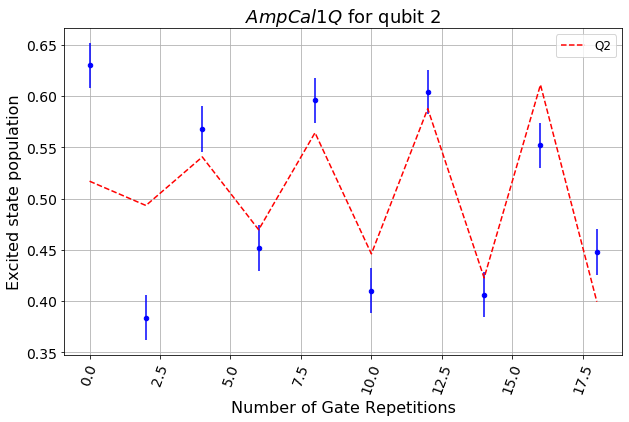

In [8]:
%matplotlib inline
# Fit the data to an oscillation

plt.figure(figsize=(10, 6))
initial_theta = 0.02
initial_c = 0.5
initial_phi = 0.1


fit = AmpCalFitter(backend_result1, xdata, qubits,
                   fit_p0=[initial_theta, initial_c],
                   fit_bounds=([-np.pi, -1],
                               [np.pi, 1]))

# plot the result for the number 1 indexed qubit.
# In this case that refers to Q2 since we passed in as [4, 2])
fit.plot(1, ax=plt.gca())
    
print("Rotation Error on U2: %f rads"%(fit.angle_err()[0]))
plt.show()

## Angle Error Characterization for Single Qubit Gates

Measure the angle between the X and Y gates

In [9]:
qubits = [0,1]
circs, xdata = anglecal_1Q_circuits(10, qubits, angleerr=0.1)

Gate sequence for measureing the angle error

In [10]:
#The U1 gates are added errors to test the procedure
print(circs[2])

         ┌─────────┐┌──────────┐┌────────────────┐┌────────────────┐┌─────────┐»
q2_0: |0>┤ U2(0,0) ├┤ U1(-0.2) ├┤ U2(-pi/2,pi/2) ├┤ U2(-pi/2,pi/2) ├┤ U1(0.2) ├»
         ├─────────┤├──────────┤├────────────────┤├────────────────┤├─────────┤»
q2_1: |0>┤ U2(0,0) ├┤ U1(-0.2) ├┤ U2(-pi/2,pi/2) ├┤ U2(-pi/2,pi/2) ├┤ U1(0.2) ├»
         └─────────┘└──────────┘└────────────────┘└────────────────┘└─────────┘»
 c2_0: 0 ══════════════════════════════════════════════════════════════════════»
                                                                               »
 c2_1: 0 ══════════════════════════════════════════════════════════════════════»
                                                                               »
«      ┌─────────┐┌─────────┐┌──────────┐┌────────────────┐┌────────────────┐»
«q2_0: ┤ U2(0,0) ├┤ U2(0,0) ├┤ U1(-0.2) ├┤ U2(-pi/2,pi/2) ├┤ U2(-pi/2,pi/2) ├»
«      ├─────────┤├─────────┤├──────────┤├────────────────┤├────────────────┤»
«q2_1: ┤ U2(0,0) ├┤ U2(0,0) ├┤ U1(

In [11]:
# Set the simulator 
# Run the simulator
backend = qiskit.Aer.get_backend('qasm_simulator')
shots = 1000
backend_result1 = qiskit.execute(circs, backend,
                                shots=shots).result()

Angle error between X and Y: 0.096766 rads


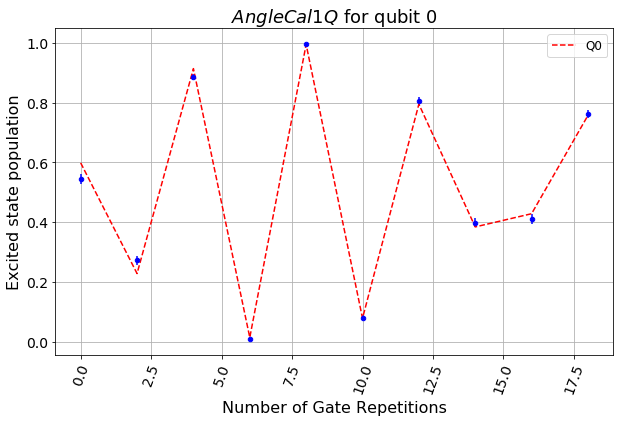

In [12]:
%matplotlib inline
# Fit the data to an oscillation

plt.figure(figsize=(10, 6))
initial_theta = 0.02
initial_c = 0.5
initial_phi = 0.01


fit = AngleCalFitter(backend_result1, xdata, qubits,
                   fit_p0=[initial_theta, initial_c],
                   fit_bounds=([-np.pi, -1],
                               [np.pi, 1]))

fit.plot(0, ax=plt.gca())
    
print("Angle error between X and Y: %f rads"%(fit.angle_err()[0]))
plt.show()

## Amplitude Error Characterization for CX Gates

This looks for a rotation error in the CX gate, ie., if the gate is actually $CR_x(\pi/2+\delta)$ measure $\delta$. This is very similar to the single qubit amplitude error calibration except we need to specify a control qubit (which is set to be in state $|1\rangle$) and the rotation is a $\pi$.

In [13]:
# We can specify more than one CX gate to calibrate in parallel
# but these lists must be the same length and not contain
# any duplicate elements
qubits = [0,2]
controls = [1,3]
circs, xdata = ampcal_cx_circuits(15, qubits, controls)

Gate sequence to calibrate the amplitude of the CX gate on Q0-Q1 and Q2-Q3 in parallel

In [14]:
print(circs[2])

         ┌────────────────┐┌───┐┌───┐┌─┐   
q3_0: |0>┤ U2(-pi/2,pi/2) ├┤ X ├┤ X ├┤M├───
         └─────┬───┬──────┘└─┬─┘└─┬─┘└╥┘   
q3_1: |0>──────┤ X ├─────────■────■───╫────
         ┌─────┴───┴──────┐┌───┐┌───┐ ║ ┌─┐
q3_2: |0>┤ U2(-pi/2,pi/2) ├┤ X ├┤ X ├─╫─┤M├
         └─────┬───┬──────┘└─┬─┘└─┬─┘ ║ └╥┘
q3_3: |0>──────┤ X ├─────────■────■───╫──╫─
               └───┘                  ║  ║ 
 c3_0: 0 ═════════════════════════════╩══╬═
                                         ║ 
 c3_1: 0 ════════════════════════════════╩═
                                           


In [15]:
# Set the simulator 
# Add a rotation error on CX
# only if the control is in the excited state
err_unitary = np.eye(4,dtype=complex)
angle_err = 0.15
for i in range(2):
    err_unitary[2+i,2+i] = np.cos(angle_err)
    err_unitary[2+i,2+(i+1) % 2] = -1j*np.sin(angle_err)

error = coherent_unitary_error(err_unitary)
noise_model = NoiseModel()
noise_model.add_nonlocal_quantum_error(error, 'cx', [1,0], [0,1])

# Run the simulator
backend = qiskit.Aer.get_backend('qasm_simulator')
shots = 1500
backend_result1 = qiskit.execute(circs, backend,
                                shots=shots, noise_model=noise_model).result()

Rotation Error on CX: 0.007362 rads


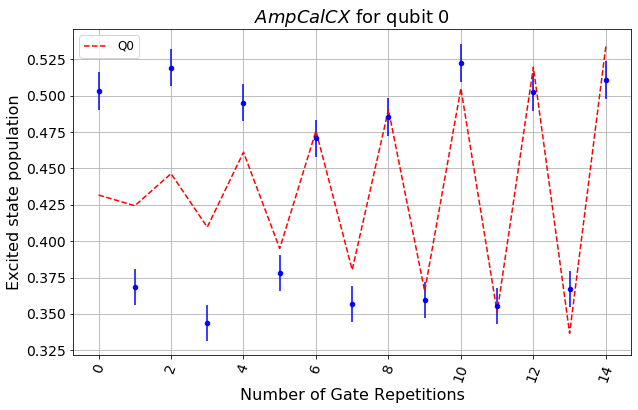

In [16]:
%matplotlib inline
# Fit the data to an oscillation

plt.figure(figsize=(10, 6))
initial_theta = 0.02
initial_c = 0.5
initial_phi = 0.01


fit = AmpCalCXFitter(backend_result1, xdata, qubits,
                   fit_p0=[initial_theta, initial_c],
                   fit_bounds=([-np.pi, -1],
                               [np.pi, 1]))

fit.plot(0, ax=plt.gca())
    
print("Rotation Error on CX: %f rads"%(fit.angle_err()[0]))
plt.show()

## Angle Error Characterization for CX Gates

Measure the angle error $\theta$ in the CX gate, i.e., $CR_{\cos(\theta)X+\sin(\theta)Y}(\pi/2)$ with respect to the angle of the single qubit gates.

In [17]:
qubits = [0,2]
controls = [1,3]
circs, xdata = anglecal_cx_circuits(15, qubits, controls, angleerr=0.1)

Gate sequence to calibrate the CX angle for Q0-Q1 and Q3-Q4 in parallel

In [18]:
print(circs[2])

         ┌─────────┐┌──────────┐┌───┐┌─────────┐┌───┐┌──────────┐┌───┐»
q4_0: |0>┤ U2(0,0) ├┤ U1(-0.1) ├┤ X ├┤ U1(0.1) ├┤ Y ├┤ U1(-0.1) ├┤ X ├»
         └──┬───┬──┘└──────────┘└─┬─┘└─────────┘└───┘└──────────┘└─┬─┘»
q4_1: |0>───┤ X ├─────────────────■────────────────────────────────■──»
         ┌──┴───┴──┐┌──────────┐┌───┐┌─────────┐┌───┐┌──────────┐┌───┐»
q4_2: |0>┤ U2(0,0) ├┤ U1(-0.1) ├┤ X ├┤ U1(0.1) ├┤ Y ├┤ U1(-0.1) ├┤ X ├»
         └──┬───┬──┘└──────────┘└─┬─┘└─────────┘└───┘└──────────┘└─┬─┘»
q4_3: |0>───┤ X ├─────────────────■────────────────────────────────■──»
            └───┘                                                     »
 c4_0: 0 ═════════════════════════════════════════════════════════════»
                                                                      »
 c4_1: 0 ═════════════════════════════════════════════════════════════»
                                                                      »
«      ┌─────────┐┌───┐┌────────────────┐┌─┐   
«q4_0: ┤ U1(0.1)

In [19]:
# Set the simulator 
# Run the simulator
backend = qiskit.Aer.get_backend('qasm_simulator')
shots = 1000
backend_result1 = qiskit.execute(circs, backend,
                                shots=shots).result()

Rotation Error on CX: 0.100348 rads


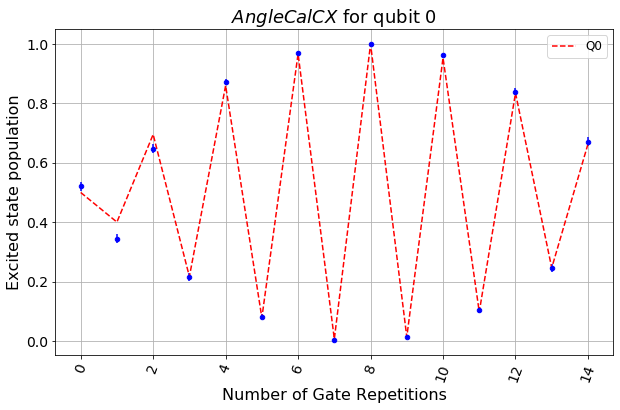

In [20]:
%matplotlib inline
# Fit the data to an oscillation

plt.figure(figsize=(10, 6))
initial_theta = 0.02
initial_c = 0.5
initial_phi = 0.01


fit = AngleCalCXFitter(backend_result1, xdata, qubits,
                   fit_p0=[initial_theta, initial_c],
                   fit_bounds=([-np.pi, -1],
                               [np.pi, 1]))

fit.plot(0, ax=plt.gca())
    
print("Rotation Error on CX: %f rads"%(fit.angle_err()[0]))
plt.show()